# Settings for the project testing and recreating results from scratch

In [0]:
VERBOSE = False              # True = more info is printed 
RUN_TESTS = True             # True = tests and rersults are shown 

GENERATE_DATA_VAE = False    # True = create new data for training VAE
GENERATE_DATA_LSTM = False   # True = create new data for training LSTM

RETRAIN_VAE = False          # True = train VAE from scratch
RETRAIN_LSTM = False         # True = train LSTM from scratch 
RETRAIN_CONTROLLER = False   # True = train controller from scratch 
                             #       (cotroller type can be specified in section controller training)

# Mounting GDrive and crating project file structure


In [2]:
import os
from google.colab import drive


'''
Mounting google drive to this project
'''
# path to the current user's google drive 
DRIVE_PATH = '/content/gdrive'
drive.mount(DRIVE_PATH)


'''
Defining folder paths
'''

MYDRIVE =  os.path.join(DRIVE_PATH,  'My Drive')


def create_folder(existing_dir, new_dir):
  full_path = os.path.join(existing_dir, new_dir)
  os.makedirs(full_path, exist_ok=True)
  return full_path

# project folder
PROJECT_DIR = create_folder(MYDRIVE, 'world_models') 

# folder with data generated for training
DATA_DIR = create_folder(PROJECT_DIR, 'data') 

# folder with saved models and their training performance 
SAVED_MODELS_DIR = create_folder(PROJECT_DIR, 'saved_models') 

VAE_DIR = create_folder(SAVED_MODELS_DIR, 'vae') 
VAE_MODEL_DIR = create_folder(VAE_DIR, 'model') 
LSTM_DIR = create_folder(SAVED_MODELS_DIR, 'lstm') 
CONTROLLER_DIR = create_folder(SAVED_MODELS_DIR, 'controller') 

# folder where data for tesorboard will be stored and loaded
LOGDIR_DIR= create_folder(VAE_DIR, 'logdir') 

# folder for storing pictures from training and tests
PICTURES_DIR = create_folder(PROJECT_DIR, 'pictures') 
GRAPHS_DIR = create_folder(PROJECT_DIR, 'graphs') 
RESIZE_METHODS_DIR = create_folder(PICTURES_DIR, 'resize_methods') 
LSTM_PROGRESS_DIR = create_folder(PICTURES_DIR, 'lstm_progress') 
VISUALIZATIONS_DIR = create_folder(PICTURES_DIR, 'visualizations')
VAE_PROGRESS_DIR = create_folder(VAE_DIR, 'progress') 

'''
Defining file paths
'''
VAE_MODEL_DATA_PATH = os.path.join(VAE_MODEL_DIR, 'vae_model_data')
VAE_SAMPLE_IMAGE = os.path.join(VAE_PROGRESS_DIR, 'sample_image')

VAE_TRAIN_DATA_PATH = os.path.join(DATA_DIR, 'data_for_VAE_')
VAE_VALID_DATA_PATH = os.path.join(DATA_DIR, 'valid_data_for_VAE_') 

LSTM_TRAIN_DATA_PATH = os.path.join(DATA_DIR, 'train_data_for_LSTM_')
LSTM_CHECKPOINT_PATH =  os.path.join(LSTM_DIR, 'checkpoint.pt')


if __name__ == '__main__':
  if VERBOSE:
    print('Project structure is created:')
    for path, dirs, files in os.walk(PROJECT_DIR):
      print(path)
 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Wrapper for the skiing environment

In [0]:
# Google few days back updated numpy version in Collaboratory. See in issue: 
# https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
# so it is downgraded to be compatible with current source code
!pip uninstall numpy       
!pip install numpy==1.16.1  

import numpy as np
from gym.envs.atari import AtariEnv
import cv2

# Definition of actions
DOWN = 0
RIGHT = 1
LEFT = 2

class SkiingWrapper(AtariEnv):
  '''
  The SkiingWrapper object is used for better interaction with the environment
  and broadened for helper functions. 
  
  '''
  
  
  def __init__(self, interpolation=cv2.INTER_CUBIC, env_reward = False):
    '''Initialize Skiing wrapper
    
    Parameters:
     * interpolation (cv2.interpolstion Method): Is defining a method for resizing observation
     * env_reward (bool): True - original environment reward is used
                          False - our redefined reward system is used
    
    '''
    
   
    # Call the base class constructor on skiing env. and observation type RGB image 
    super(SkiingWrapper, self).__init__(game='skiing', obs_type='image')
    
    # Set env. properties
    self.env_reward = env_reward
    self.interpolation = interpolation
    self.obs_space = (128, 128) # size of the resized observation
  
  
  def reset(self):
    '''Reset the game to new start and set new game variable values
    
     Returns:
      * observation (np.array(128,128,3)): Preprocessed observation of the first frame
    
    '''
    
    observation = super(SkiingWrapper, self).reset()
    self._init_reward_system_variables(observation)
    return self._preprocess_observation(observation)

  
  def step(self, action):
    '''Make a step in the environment on provided action
    
    Parameters:
      * action (int){0,1,2}: Direction for the skier
      
    Returns:
      * observation (np.array(128,128,3)): Preprocessed observation  
      * reward (int): Reward for being in the current state 
      * done (bool): True - game is over
                     False - game is not over 
    
    '''
    
    
    observation, reward, done, _ = super(SkiingWrapper, self).step(action)
    
    if self.env_reward:
      # Return original env. reward
      return self._preprocess_observation(observation), reward, done, {}
    
    # Return our redefined reward
    return self._preprocess_observation(observation), self._get_reward(observation), done, {}
    
    
    
  def _init_reward_system_variables(self, observation):
    '''Set parameters for detecting rewards
      
      Parameters:
        * observation np.array(250,160,3): Raw observation provided by original env. 
        
    '''
    
    self.previous_score_image = self._get_score(observation)
    self.previous_frame = self._crop_observation(observation)
    self.crashed = True # First two frames are the same after the reset()

  def _get_reward(self, observation):
    ''' Calculate redefined reward    
    
    For optimization we override reward system.
    The reward is: 
       -5: skier has crashed
        0: skier is moving
     +100: skier went through the slalom

    It is detected by changes in score on the frame and changes of the frames
    
    Parameters:
      * observation np.array(250,160,3): Raw observation provided by original env. 
      
    Returns:
      * reward (int): Reward for being in the current state
    
    '''
    
    reward = 0
    current_score_image = self._get_score(observation)
    current_cropped_frame = self._crop_observation(observation)
    
    # SCORE HAS CHANGED - skier went through the slalom
    if np.array_equal(self.previous_score_image, current_score_image) == False:
      reward += 100

    # FRAME STAYED THE SAME - skier has crashed 
    if np.array_equal(self.previous_frame, current_cropped_frame):
      if self.crashed == False:
        self.crashed = True
        reward -= 5 
    else:
      self.crashed = False
    
    # Set current values for next reward evaluation
    self.previous_score_image = self._get_score(observation)
    self.previous_frame = self._crop_observation(observation)

    return reward
  
  
  
  def _get_score(self, observation):
    ''' Return pixel values, where score is stored
    
    Parameters:
      * observation np.array(250,160,3): Raw observation provided by original env. 
    
    Retruns:
      * score(array): Part of observation, where score is showed
    '''

    return observation[0:40,65:85]

  
  
  def _preprocess_observation(self, observation):
    ''' Make modification to observation for better VAE performance
    
    Returns:
      * observation (np.array(128,128,3)): Preprocessed observation 
    
    '''
    
    observation = self._recolor_skier(observation)
    observation = self._crop_observation(observation)
    observation = self._resize_observation(observation) 
    observation = self._normalize_observation(observation)
    
    return observation
 

  def _recolor_skier(self, observation):
    ''' Apply more contreasting color to skier
    
    Reason for this was poor performance of the VAE on 
    the original skier color.
    
    Parameters:
      * observation np.array(250,160,3): Raw observation provided by original env. 
      
    Returns:
      * observation np.array(250,160,3): Observation with recolored skier 
    
    '''
    
    _SKIER_ORIGINAL_COLOR = [214,92,92]
    _SKIER_NEW_COLOR = [0,0,0]
    
    mask = (observation == _SKIER_ORIGINAL_COLOR).all(axis=2)
    observation[ mask ] = _SKIER_NEW_COLOR
    
    return observation
  
  
  def _crop_observation(self, observation):
    ''' Crop observation to contain only necessary information
    
    
    Reason for this was downsizing the observation so we could use as small 
    latent vector in VAE compression.
    
    Parameters:
      * observation np.array(250,160,3): Raw observation provided by original env. 
      
    Returns:
      * observation np.array(150,148,3): Observation without the score and frame
    
    '''
    
    # image with skier and slalom
    START_WIDTH = 8
    STOP_WIDTH = 152
    START_HEIGHT = 50
    STOP_HEIGHT = 200
    
    return observation[START_HEIGHT:STOP_HEIGHT,START_WIDTH:STOP_WIDTH]

  
  def _resize_observation(self, observation):
    ''' Resize observation size to exponent of 2 - 128x128x3
    
    
    Reason for this making easier calculation in the VAE.
    
    Parameters:
      * observation np.array(150,148,3): Cropped observation 
      
    Returns:
      * observation np.array(128,128,3): Resized observation
    
    '''
    
    
    return cv2.resize(observation, dsize=self.obs_space, interpolation=self.interpolation)

  
  def _normalize_observation(self, observation):
    ''' Normalize observation data between 0 and 1 for better VAE performance
    
    Parameters:
      * observation np.array(128,128,3): Resized observation 
      
    Returns:
      * observation np.array(128,128,3): Normalized observation
    
    '''
    
    
    return observation.astype('float32') / 255.

  
  
  
def make_env(interpolation=cv2.INTER_CUBIC, env_reward = False):
  '''Return skiing environment
    
    Parameters:
     * interpolation (cv2.interpolstion Method): Is defining a method for resizing observation
     * env_reward (bool): True - original environment reward is used
                          False - our redefined reward system is used
    
    Returns:
      env (SkiingWrapper): Skiing-V0 environment
    
  '''

  env = SkiingWrapper(interpolation=interpolation, env_reward = env_reward)

  if VERBOSE:
    print("Environment details")
    print("action space", env.action_space)
    print("action space example:", env.action_space.sample())
    print("observation_space: ", env.obs_space)

    

  return env

## Save different resize methods for comparison


In [4]:
import scipy.misc

def save_different_resize_methods_results(frames_num=1):
  '''Save observation resize using different interpolation methods for comparsion
  
  Parameters:
    frame_num (int): number of frames fro each method to be saved
  '''

  
  methods=[
     ("area", cv2.INTER_AREA), 
     ("nearest", cv2.INTER_NEAREST), 
     ("linear", cv2.INTER_LINEAR), 
     ("cubic", cv2.INTER_CUBIC), 
     ("lanczos4", cv2.INTER_LANCZOS4)
  ]
  
  
  for name, method in methods:
    env = SkiingWrapper(interpolation = method)
    
    #Set same env. initial seed for better comparison 
    env.seed(0)
    env.reset()
    for i_step in range(frames_num): 
      # Choose random action
      action = env.action_space.sample() 
      observation, reward, done, info = env.step(action)
      # Save observation with name and step
      scipy.misc.imsave(RESIZE_METHODS_DIR  + '/' + '{}_{}.png'.format(name, i_step), observation)

      if done: 
        break

if __name__ == "__main__":
  if RUN_TESTS:
    save_different_resize_methods_results(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


# Generating data for VAE

In [0]:
import multiprocessing as mp
import numpy as np

'''
DATA GENERATING FOR VAE - SETTINGS
'''
# ---------------------
BATCH_SIZE = 1               # number of games played in a batch
NUM_TRAIN_BATCHES_VAE = 16   # number of generated batches for training
NUM_VALID_BATCHES_VAE = 4    # number of generated batches for validation
# ---------------------


NUM_BATCHES_VAE = NUM_VALID_BATCHES_VAE + NUM_TRAIN_BATCHES_VAE


def save_batch_for_vae(batch_num):
  ''' Generate and save training and validation data for 
    VAE training - best working resize method is used by default
    
    Generated data contaion observation from random policy runs.
    
    Parameters:
      * batch_num (int): number of the generated batch
  
  
  '''
  
  # Random policy frames data generating
  env = make_env()
  observation_data = []

  for _ in range(BATCH_SIZE):    
    
    observation = env.reset()
    
    while True: 
      
      observation_data.append(observation)     
      action = env.action_space.sample()
      observation, reward, done, info = env.step(action)
           
      if done: 
        break
        
  if VERBOSE:
    print("Saving new VAE dataset for a batch {}".format(batch_num))
    
  # Saving batch data  
  if batch_num < NUM_TRAIN_BATCHES_VAE:  
    np.save('{}{}'.format(VAE_TRAIN_DATA_PATH, batch_num), observation_data)
  else:
    np.save('{}{}'.format(VAE_TRAIN_DATA_PATH, batch_num), observation_data)
    
  env.close()

  
def generate_data_for_vae():
  '''Use multiprocessing for faster data generating'''
  
  
  if VERBOSE:
    print("Generating data for VAE - env Skiing-v0")
  
  # Multiprocessor generating
  with mp.Pool(mp.cpu_count()) as p:
    p.map(save_batch_for_vae, range(NUM_BATCHES_VAE))

if __name__ == "__main__":
  if GENERATE_DATA_VAE:
    generate_data_for_vae()

# VAE

In [0]:
import tensorflow as tf
import numpy as np
import glob, random, os

if not VERBOSE: 
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


LATENT_Z_DIM = 256   # size of z in VAE
  
class VAE(object):
  '''
  The VAE object represents variational autoencoder tensorflow model used 
  for compressing image data to the latent vector "z" or reconstruction of the provided 
  latent vector "z" to the RGB observation .
  '''
  
  # Create model
  def __init__(self):
    '''Initialize VAE model'''
    
    # Set input data dimension and types
    self.original = tf.placeholder(tf.float32, [None, 128, 128, 3], name='image')
    
    # Put encoder, latent vector and decoder parts together
    self.mu, self.log_var = self._encode(self.original)
    self.z = self._compute_z(self.mu, self.log_var)
    self.reconstruction = self._decode(self.z)
    
    # Set loss
    self.loss = self._compute_loss()
    
    # Set summary for TesorBoard ouput
    tf.summary.image('original', self.original, 10)
    tf.summary.image('reconstruction', self.reconstruction, 10)    
    self.merged = tf.summary.merge_all()



  def _encode(self, x):
    '''Encode input image data to mean ("mu") & log variance ("log_var") 
    
      The encoder network behaves like Q(z|x) and outputs μ(x) and log_var(x), 
      the parameters of the Gaussian. 
      
      Parameters:
        * x: Preprocessed observation of size (128,128,3)
        
      Returns:
        * mu: Vector of size 256 reresenting mean of the Gaussian
        * log_var: Vector of size 256 reresenting log variance of the Gaussian
        
    '''
    
    x = tf.layers.conv2d(x, filters=32,  kernel_size=4, strides=2, padding='valid', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=64,  kernel_size=4, strides=2, padding='valid', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=128, kernel_size=4, strides=2, padding='valid', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=256, kernel_size=4, strides=2, padding='valid', activation=tf.nn.relu)

    x = tf.layers.flatten(x)
    mu = tf.layers.dense(x, units=256, name='mu')
    log_var = tf.layers.dense(x, units=256, name='log_var')
    
    return mu, log_var

  
  def _compute_z(self, mu, log_var):
    '''From mean and log variance compute latent vector "z" 
    
      Sampling  "z" from a Gaussian directly don't work as the sampling operation
      doesn’t have a gradient. So reparameterization trick, is used which makes the 
      network differentiable. Its idea lays behind the fact that if we sample from a 
      standard normal distribution, we could convert it to any Gaussian we want if we 
      know the mean and the variance. 
      
      So sampling operation of "z" is done like:
        z = μ(x) + sigma(x) * eps, 
        where eps ∼ N(0,1)
        
      As the sampling doesn’t depend on anything in our network,
      the gradient won’t flow through it.
    
      Parameters:
        * mu: Mean of the Gaussian
        * log_var: Log variance of the Gaussian
        
      Returns:
        * z: Latent vector of size 256 - contaning compressed data of the input 
    
    
    '''
    
    eps = tf.random_normal(shape=tf.shape(mu))
    sigma = tf.exp(log_var / 2)
    
    z = mu + sigma * eps
    
    return z
  
  def _decode(self, z):
    '''Decode from latent vector "z"
      
      The decoder network behaves like P(x|z) and outputs the reconstruected data.
      
      
      Parameters:
        * z: Latent vector
        
      Returns:
        * x: Decoded observation
    
    '''
    
    x = tf.layers.dense(z, 1024, activation=None)
    x = tf.reshape(x, [-1, 1, 1, 1024])
    x = tf.layers.conv2d_transpose(x, filters=128, kernel_size=5, strides=2, padding='valid', activation=tf.nn.relu)
    x = tf.layers.conv2d_transpose(x, filters=64,  kernel_size=5, strides=2, padding='valid', activation=tf.nn.relu)
    x = tf.layers.conv2d_transpose(x, filters=32,  kernel_size=5, strides=2, padding='valid', activation=tf.nn.relu)
    x = tf.layers.conv2d_transpose(x, filters=16,  kernel_size=6, strides=2, padding='valid', activation=tf.nn.relu)
    x = tf.layers.conv2d_transpose(x, filters=3,   kernel_size=6, strides=2, padding='valid', activation=tf.nn.sigmoid)
    
    return x

  def _compute_loss(self):
    '''Compute loss as reconstruction loss + KL loss
      
      Retruns:
       * vae_loss (float): Value representing errror of the reconstructions
       
    '''
    
    # MSE of generated_image - real_image => how close is the image to the original
    reconstruction_loss = tf.reduce_sum(tf.square(self.original - self.reconstruction), reduction_indices = [1,2,3])
        
    # D_KL(Q(z|x) || P(z|x)) => How closely the latent variables match a unit gaussian.
    # explained here https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
    kl_loss = 0.5 * tf.reduce_sum(tf.exp(self.log_var) + self.mu**2 - 1. - self.log_var, 1)
    
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    return vae_loss

def reset_graph():
  '''Close opened session and reset default graph'''
  
  if 'sess' in globals() and sess:
    sess.close()
  tf.reset_default_graph() 
  

def load_vae():
  '''Load VAE and return it with tf session
  
    Returns: 
      * sess: Tensorflow session
      * vae: Tensorflow graph defined by VAE model
  '''
  
  reset_graph()
  
  # Set new default tf Graph
  graph = tf.Graph()
  with graph.as_default():
    # Set default parameters and load VAE
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config, graph=graph)

    vae = VAE()
    init = tf.global_variables_initializer()
    sess.run(init)

    saver = tf.train.Saver(max_to_keep=1)

    try:
      saver.restore(sess, tf.train.latest_checkpoint(VAE_MODEL_DIR))
    except  Exception as e:
      raise ImportError("Could not restore saved VAE model. {}".fromat(e))

    return sess, vae


# Training VAE

### Running TensorBoard

In [0]:
def run_tensorboard():
  ''' Download and run TesorBoard 
  
    TensorBoard will be opened in a new tab after clicking on the generated link
  
  '''

  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip

  get_ipython().system_raw(
      "tensorboard --logdir '{}' --host 0.0.0.0 --port 6006 &"
      .format(LOGDIR_DIR)
  )
  get_ipython().system_raw('./ngrok http 6006 &')

  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

if __name__ == "__main__":
  if RETRAIN_VAE:
    run_tensorboard()


### Test data preparation / result functions

In [0]:
import numpy as np
import tensorflow as tf
import scipy.misc

def count_VAE_model_variables():
  '''Print VAE parameter's trainable variable count
     and total trainable variable count  
  '''
  # modified code from a user nessuno as an answer to stackoverflow question:
  # https://stackoverflow.com/questions/38160940/how-to-count-total-number-of-trainable-parameters-in-a-tensorflow-model
  
  reset_graph()
  vae = VAE()

  total_parameters = 0
  for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
      variable_parameters *= dim.value
      print("Variable: {} - {} params".format(variable, variable_parameters))
      total_parameters += variable_parameters
  print("Total number of model trainable parameters: {}".format(total_parameters))

  
  
def create_sample_image_data():  
  '''Sample few frames for VAE rconstruction progress demostration'''
  
  DUMMY_RANGE = 10000 # more than in worst rollout
  
  env = make_env()
  env.reset()
  
  for i_step in range(DUMMY_RANGE):    
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

    if i_step % 100 == 0:
      # Save as images and as nupy data, for reconstruction during the training 
      scipy.misc.imsave(VAE_SAMPLE_IMAGE  + '{}.png'.format(i_step), observation)
      np.save(VAE_SAMPLE_IMAGE + '{}.npy'.format(i_step), observation)
    if done: 
      break
      
if __name__ == "__main__":      
  if RUN_TESTS:  
#     count_VAE_model_variables()    
    pass

  if RETRAIN_VAE:
    create_sample_image_data()


### VAE Training

In [0]:
import numpy as np
import os
import glob
import scipy.misc

GLOBAL_STEP_PATH = os.path.join(VAE_DIR, 'global_step.npy')
TRAIN_LOSS_PATH = os.path.join(VAE_DIR, 'train_loss.npy')
VALID_LOSS_PATH = os.path.join(VAE_DIR, 'valid_loss.npy')
VAE_MODEL_PATH = os.path.join(VAE_DIR, 'vae_model')
PROGRESS_IMAGE_PATH = os.path.join(VAE_PROGRESS_DIR, 'step_')

      
def vae_data_iterator(batch_size, data_path):
  '''Return random frames from saved rollouts
  
    Parameters:
      * batch_size (int): Number of frames per batch we want to return
      * data_path (string): Path to the data we want to 
      
    Returns:
      * data (list): List of randomly selected frames from saved rollouts
  
  '''
  
  # Get specified files names
  data_files = glob.glob(data_path + '*')
  while True:
    # Select random recorded session.
    data = np.load(random.sample(data_files, 1)[0])
    
    # Shuffle order of frames
    np.random.shuffle(data)

    # Return batch_size frames   
    N = data.shape[0]
    start = np.random.randint(0, N-batch_size)
    yield data[start:start+batch_size]

   
    
def train_vae():
  '''Train VAE and save progress'''
  
  reset_graph()
  # Create a session.
  sess = tf.InteractiveSession()
  
  # Create a variable to hold the global_step. - total number of steps during training
  global_step = tf.Variable(0, name='global_step', trainable=False)
  
  train_loss = np.empty
  validation_loss = np.empty
 
  # Create a summary writer, add the 'graph' to the event file.
  writer = tf.summary.FileWriter(LOGDIR_DIR)

  # VAE:  
  vae = VAE()

  # Add the AdamOptimizer 0.0001, 0.00001
  optimizer = tf.train.AdamOptimizer(0.0001).minimize(vae.loss, global_step=global_step)
  
  # Inicialize the variables 
  tf.global_variables_initializer().run()

  # Saves and restore variables. Maximum number of recent checkopoints to keeep set to 2
  saver = tf.train.Saver(max_to_keep=2)

  step = global_step.eval()
  
  
  # Generator for getting training data
  train_data = vae_data_iterator(batch_size=64, data_path=VAE_TRAIN_DATA_PATH )
  valid_data = vae_data_iterator(batch_size=64, data_path=VAE_VALID_DATA_PATH )
  
  # If trained restore model
  try:
    saver.restore(sess, tf.train.latest_checkpoint(VAE_MODEL_DIR))
    step = np.load(GLOBAL_STEP_PATH) + 1
    train_loss =  np.load(TRAIN_LOSS_PATH)
    validation_loss = np.load(VALID_LOSS_PATH)
    print("VAE restored from: {}".format(VAE_MODEL_DIR))
  except Exception as e:
    print("Could not restore VAE's saved model: {}".format(e))

  try:
    while True:
      images = next(train_data)
      _ , loss_value, summary = sess.run([optimizer, vae.loss, vae.merged],
                feed_dict={vae.original: images})

      writer.add_summary(summary, step)

      # Evaluate Loss
      if step % 10 == 0:
        # train
        images = next(train_data)      
        _, train_loss_value = sess.run([optimizer, vae.loss], feed_dict={vae.original: images})
        train_loss = np.append(train_loss, train_loss_value)

        # validation
        images = next(valid_data)
        validation_loss_value = sess.run([vae.loss], feed_dict={vae.original: images})
        validation_loss  = np.append(validation_loss, validation_loss_value)

      if np.isnan(loss_value):
        raise ValueError('Loss value is NaN')

      # Print loss
      if step % 100 == 0 and step > 0:
        print ('Step {}: training loss {:.4f}'.format(step, loss_value))

      # Save model
      if step % 1000 == 0:
        print('Saving the VAE model')
        save_path = saver.save(sess, VAE_MODEL_PATH, global_step=global_step)
        np.save(GLOBAL_STEP_PATH, step)
        np.save(TRAIN_LOSS_PATH, train_loss)
        np.save(VALID_LOSS_PATH, validation_loss)

      # Save current image state
      if step % 2000 == 0:
        print('Saving image samples')
        # Load images for future progress comparison
        for file_num, file_name in  enumerate(glob.glob(VAE_SAMPLE_IMAGE + '*.npy')):
          image = np.load(file_name)
          reconstructed = sess.run([vae.reconstruction], feed_dict={vae.original: image.reshape(-1,128,128,3)})
          np_reconstructed = np.array(reconstructed[0])

          scipy.misc.imsave(PROGRESS_IMAGE_PATH  + '{}_{}.png'.format(file_num, step), np_reconstructed.reshape(128,128,3))
          np.save(PROGRESS_IMAGE_PATH + '{}_{}.npy'.format(file_num, step), reconstructed)

      # Loss value is ok - stop training
      if loss_value <= 80:
        print ('step {}: training loss {:.6f}'.format(step, loss_value))
        save_path = saver.save(sess, VAE_MODEL_PATH, global_step=global_step)
        break
      step+=1
  except (KeyboardInterrupt, SystemExit):
    print("Manual Interrupt")
  except Exception as e:
    print("Exception: {}".format(e))
  finally:
    sess.close()


  
if __name__ == "__main__":      
  if RETRAIN_VAE:      
    train_vae()

### Plotting VAE training results

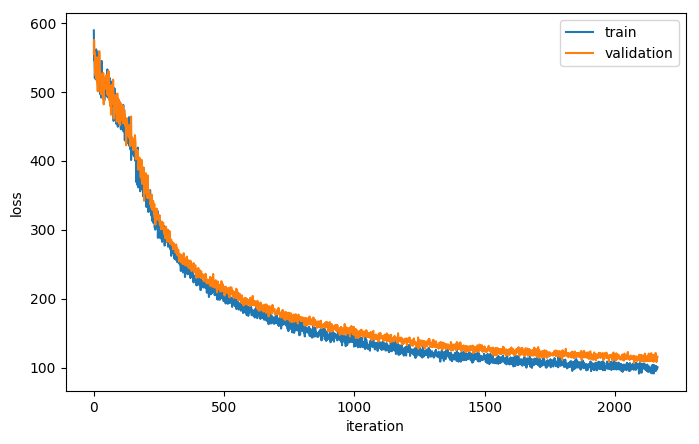

In [10]:
import numpy as np 
from matplotlib import pyplot as plt

def save_vae_loss_graph():
  '''Save the difference between training and validation loss'''
  
  train_loss =  np.load(TRAIN_LOSS_PATH)
  validation_loss = np.load(VALID_LOSS_PATH)

  fig=plt.figure(figsize=(8, 5), dpi= 100, facecolor='w', edgecolor='k')

  line_train, = plt.plot( train_loss[50:]) # first iterations would break the graph
  line_valid, = plt.plot(validation_loss[50:])

  plt.legend([line_train, line_valid], ['train', 'validation'])
  plt.xlabel('iteration')
  plt.ylabel('loss')
  

  
  plt.savefig(GRAPHS_DIR + "/vae_loss.svg")
  plt.show()
  
if __name__ == "__main__":      
  if RUN_TESTS:      
    save_vae_loss_graph()



# Generating data for LSTM

In [0]:
 
'''
LSTM DATA GENERATION SETTINGS
'''
#-------------------------
NUM_TRAIN_BATCHES_LSTM = 32
#-----------------------


def generate_batch_for_lstm(batch_num):
  '''Generate batch of training data for MDN-LSTM 
    
    The saved data is latent vector z from V containing compressed observation 
    and an action. Reward was also saved but only for tests.  
  
    Parameters:
      * batch_num (int): batch number for file name
  
  '''
  
  sess, vae = load_vae()

  observation_data = []
  action_data = []
  reward_data = []

  
  env = make_env()
  observation = env.reset()
  
  reward = 0 
  

  while True: 
    
    action = env.action_space.sample() 
    
    observation_data.append(sess.run(vae.z, feed_dict={vae.original: observation[None, :,  :,  :]}).flatten())
    reward_data.append(reward)   
    action_data.append(action)

    observation, reward, done, info = env.step(action)
    
    if done: break


  print("Saving LSTM dataset for batch {}".format(batch_num))
  
  # Save as numpy dict
  np.save(LSTM_TRAIN_DATA_PATH + '{}'.format(batch_num), {'observation': observation_data, 'action': action_data, 'reward': reward_data})
  env.close()
  sess.close()

def generate_data_for_lstm():
  for i in range(NUM_TRAIN_BATCHES_LSTM):
    generate_batch_for_lstm(i)

if __name__ == '__main__':
  if GENERATE_DATA_LSTM:
    generate_data_for_lstm()

# LSTM

In [0]:
'''
Modified verison of djiand memory module
from World Models application on the sonic environment
https://github.com/dylandjian/retro-contest-sonic/blob/master/models/lstm.py
'''



import torch.nn as nn
import torch
import torch.nn.functional as F
import math

# from const import *
TEMPERATURE = 1.15
OFFSET = 1
HIDDEN_UNITS = 1024
HIDDEN_DIM = 1024
GAUSSIANS = 5
NUM_LAYERS = 1

PARAMS_CONTROLLER = HIDDEN_UNITS * NUM_LAYERS * 2 + LATENT_Z_DIM
MDN_CONST = 1.0 / math.sqrt(2.0 * math.pi)
CUDA = torch.cuda.is_available()

DEVICE = torch.device("cuda") if CUDA else torch.device("cpu")


class LSTM(nn.Module):
  def __init__(self, sequence_len, hidden_units, z_dim, num_layers, n_gaussians, hidden_dim):
    super(LSTM, self).__init__()
    
    self.n_gaussians = n_gaussians
    self.num_layers = num_layers
    self.z_dim = z_dim
    self.hidden_dim = hidden_dim
    self.hidden_units = hidden_units
    self.sequence_len = sequence_len
    self.hidden = self.init_hidden(self.sequence_len)
   
    self.fc1 = nn.Linear(self.z_dim + 1, self.hidden_dim)
    
    self.lstm = nn.LSTM(self.hidden_dim, hidden_units, num_layers)
    self.z_pi = nn.Linear(hidden_units, n_gaussians * self.z_dim)
    self.z_sigma = nn.Linear(hidden_units, n_gaussians * self.z_dim)
    self.z_mu = nn.Linear(hidden_units, n_gaussians * self.z_dim) 


  def forward(self, x):
    self.lstm.flatten_parameters()
    sequence = x.size()[1]

    ## Hidden state
    x = F.relu(self.fc1(x))
    z, self.hidden = self.lstm(x, self.hidden)
  
    pi = self.z_pi(z).view(-1, sequence, self.n_gaussians, self.z_dim)
    pi = F.softmax(pi, dim=2)
    pi = pi / TEMPERATURE

    sigma = torch.exp(self.z_sigma(z)).view(-1, sequence,
                    self.n_gaussians, self.z_dim)
    
    sigma = sigma * (TEMPERATURE ** 0.5)
   
    mu = self.z_mu(z).view(-1, sequence, self.n_gaussians, self.z_dim)

    return pi, sigma, mu


  def init_hidden(self, sequence):
    hidden = torch.zeros(self.num_layers, sequence, self.hidden_units, device=DEVICE)
    cell = torch.zeros(self.num_layers, sequence, self.hidden_units, device=DEVICE)
    return hidden, cell



def update_lr(lr, optimizer, step):
    LR_DECAY = 0.1
    LR_DECAY_TICK = 100000
    if step % LR_DECAY_TICK != 0 or lr <= 0.00001:
        return lr, optimizer
    
    print("[TRAIN] Decaying the learning rate !")
    lr = lr * LR_DECAY
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr, optimizer
    
def create_optimizer(model, lr, param=None):
  """ Create or load a saved optimizer """
  ADAM = True
  L2_REG = 1e-4
  MOMENTUM = 0.9 ## SGD
  if ADAM:
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=L2_REG)
  else:
    opt = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=L2_REG, momentum=MOMENTUM)

  if param:
    opt.load_state_dict(param)

  return opt



# Training LSTM

In [0]:
import torch.nn.functional as F
import gridfs
import torch
import numpy as np
import click
from torch.distributions import Normal
from torchvision.utils import save_image
import glob, random ;
from random import randint
from PIL import Image
import scipy

LSTM_TRAIN_LOSS_PATH = os.path.join(LSTM_DIR, 'lstm_train_loss.npy')


SEQUENCE = 100 # Lenght of trained frames

SAVE_ORIGINAL = True # Save original input in gif during training for comparsion

## Refresh
LOSS_TICK = 50
REFRESH_TICK = 800
SAVE_PIC_TICK = 2000
SAVE_MODEL_TICK = 1000



ACTION_SPACE_DISCRETE = 3.0 # number of descrete actions
OFFSET = 1 # just to get next data
LR = 1e-4

def load_lstm(cpu=True):
  '''Load saved LSTM model for computation on CPU or GPU
    
    Params: 
      * cpu (bool): True - use collaboratory cpu for PyTorch computatons
                    False - use CUDA for PyTorch computatons
                    
    Retruns:
      * lstm: loaded lstm model
      
  '''
  
  checkpoint = torch.load(LSTM_CHECKPOINT_PATH, map_location='cpu') 
  
  lstm = LSTM(SEQUENCE, HIDDEN_UNITS, LATENT_Z_DIM, NUM_LAYERS, GAUSSIANS, HIDDEN_DIM).to(DEVICE)
  lstm.load_state_dict(checkpoint['model_state_dict'])
  
  return lstm

def data_iterator_lstm(batch_size):
  '''Return training set of size "batch_size" for LSTM'''
  
  data_files = glob.glob(LSTM_TRAIN_DATA_PATH + '*')
  while True:
    # Select random recorded session.
    data = np.load(random.sample(data_files, 1)[0])
    
    # Get data from loaded dictanionary
    observations = data.item().get('observation')
    action = data.item().get('action')
    
    # Pick random start and return next batch_size z / actions
    data_length = len(observations)    
    start = randint(0, data_length-batch_size)
    
    yield observations[start:start+batch_size], action[start:start+batch_size] 


def train_lstm():
  """
  Train the LSTM to be able to predict the next latent vector z given the current vector z
  and an action.
  """
  
  # Initialize/load saved variables for MDN-LSTM training
  lstm = LSTM(SEQUENCE, HIDDEN_UNITS, LATENT_Z_DIM, NUM_LAYERS, GAUSSIANS, HIDDEN_DIM).to(DEVICE)
  lr = LR
  optimizer = create_optimizer(lstm, lr)
  step = 0
  loss = 0
  lstm_train_loss = []
  try:
    checkpoint = torch.load(LSTM_CHECKPOINT_PATH)
    lstm.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    step = checkpoint['step']
    loss = checkpoint['loss']
    lstm_train_loss =  np.load(LSTM_TRAIN_LOSS_PATH)
    
    print("Memory Model restored from: {}".format(LSTM_CHECKPOINT_PATH))
  except Exception as e:
    print("Could not restore saved Memory Model: {}".format(e))
  
  # Load training data
  training_data = data_iterator_lstm(batch_size=SEQUENCE)
  vae_z, actions = next(training_data)


  while True:
    
    running_loss = []

    example = {
      'encoded' : torch.tensor(vae_z, dtype=torch.float, device=DEVICE),
      'actions' : torch.tensor(actions, dtype=torch.float, device=DEVICE)/ (ACTION_SPACE_DISCRETE)
    }

    loss = train_epoch(lstm, optimizer, example)
    running_loss.append(loss)
  
    lr, optimizer = update_lr(lr, optimizer, step)
    
    ## Save model
    if step % SAVE_MODEL_TICK == 0:
      print("Saving Model")
      torch.save({
            'step': step,
            'model_state_dict': lstm.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, LSTM_CHECKPOINT_PATH)
      np.save(LSTM_TRAIN_LOSS_PATH, lstm_train_loss)

    ## Print running loss
    if step % LOSS_TICK == 0:
      print("Current iteration: %d, averaged loss: %.3f" % (step, loss))
      lstm_train_loss.append(np.mean(running_loss))
      running_loss = []

    ## Save a picture 
    if step % SAVE_PIC_TICK == 0:

      frames_cnt = 10
      
      # save original
      if SAVE_ORIGINAL:
        reconstruct_from_z(vae_z[0:frames_cnt], name = '{}_original'.format(step)) 
      
      # save predicted
      save_dreamed_prediction(lstm, vae_z, "%d_loss_%.3f"%(step, loss), frames_cnt)

    # load next data for LSTM
    vae_z, actions = next(training_data)
    step += 1


def train_epoch(lstm, optimizer, example):
  '''Train LSTM model on one epoch and return loss'''
  
  # Reset the gradients and the hidden state since we dont want to have
  # model sequence-wise relationships
  optimizer.zero_grad()
  lstm.hidden = lstm.init_hidden(SEQUENCE)

  # Concatenate action to encoded vector
  x = torch.cat((example['encoded'], example['actions'].view(SEQUENCE,1)), dim=1 )
  
  # Reshape
  x = x.view(-1, SEQUENCE, LATENT_Z_DIM + 1)

  # Shift target encoded vector
  last_frame = example['encoded'][-OFFSET].view(-1, LATENT_Z_DIM)
  target = torch.cat((example['encoded'][OFFSET:SEQUENCE], last_frame))
  
  # Feed network and compute loss
  pi, sigma, mu = lstm(x)
  loss = mdn_loss_function(pi, sigma, mu, target)
  
  # Compute dloss/dx for every parameter x which has requires_grad=True. 
  loss.backward()
  optimizer.step()

  return float(loss)


      
def mdn_loss_function(out_pi, out_sigma, out_mu, y):
  """Compute MDN loss.
  Mixed Density Network loss function, see : 
  https://mikedusenberry.com/mixture-density-networks
  
  Parameters:
    * out_pi: Probability vector that represents how much each of the predicted Gaussian  
              should contribute to the final prediction of the latent vector
    * out_sigma: Vector o variance of the proposed gausian distibutions
    * out_mu: Vector of means of the proposed gausian distibutions
    * y: target - True latent vector of the next frame z_{t+1}
  
  Returs:
    loss (float): How far our predction was from true target
    
  """

  EPSILON = 1e-6 # Constant to avoid -infiniy
  
  # Converted into a multivariate Gaussian distribution
  result = Normal(loc=out_mu, scale=out_sigma)
  
  # Reshape target
  y = y.view(-1, SEQUENCE, 1, LATENT_Z_DIM)
  
  # Evaluate on target
  result = torch.exp(result.log_prob(y))
  
  # Apply probability and sum results 
  result = torch.sum(result * out_pi, dim=2)

  result = -torch.log(EPSILON + result)
  
  return torch.mean(result)


def get_lstm_input(vae_z, action):
  '''Concate and reshape latent vector and action for feeding to LSTM'''
  
  z = torch.tensor(vae_z, dtype=torch.float, device=DEVICE).view(1, LATENT_Z_DIM)
  actions = torch.full((1, 1), action, device=DEVICE) / ACTION_SPACE_DISCRETE
  x = torch.cat((z,actions ), dim=1)

  return x.view(1, 1, LATENT_Z_DIM + 1)

def sample(seq, pi, mu, sigma):
  """ Sample a latent vector given pi, mu and sigma """

  sampled = torch.sum(pi * torch.normal(mu, sigma), dim=2)
  return sampled.view(seq, LATENT_Z_DIM)


def save_dreamed_prediction(lstm, frames_z, name, frames_cnt):
  """ Given a frame, dream of the next "frames_cnt" with action DOWN and save them as gif """

  # Inintialize and load models
  lstm.hidden = lstm.init_hidden(1)
  sess, vae = load_vae()
  env = make_env()
  
  # Take first latent vector z 
  z = torch.tensor(frames_z[0], dtype=torch.float, device=DEVICE).view(1, LATENT_Z_DIM)

  result = []
  
  # Dream - input for next prediciton is previous prediction and hidden state
  with torch.no_grad():
    for i in range(1, frames_cnt):
      action = torch.full((1, 1), DOWN, device=DEVICE) / ACTION_SPACE_DISCRETE
      new_state = torch.cat((z,action), dim=1)
      pi, sigma, mu = lstm(new_state.view(1, 1, LATENT_Z_DIM + 1))
      z = sample(1, pi, mu, sigma)
      
      result.append(z.cpu().data.numpy()[0])

  
  reconstruct_from_z(result, name)
  
def reconstruct_from_z(frames_z = None, name = None, out_type="gif"):
  '''Reconstruct and save image from given compressed frames 
    in latent vector z
  
    Parameters:
      * frames_z (list): Latent vecotors z 
      * name (string): Name of the file
      * out_type (string): Sepcifies if gif, or static image
      
    
  '''
  
  sess, vae = load_vae()
    
  imgs_comb = None # jpg output
  images_gif = []  # gif output
  
  # gif has limited color palette
  palette = (0,0,0, 0,255,0, 255,0,0, 255,255,0) + (0,0,0)*252 
  
  frame = None  
  for i, z in enumerate(frames_z): 
    recon = sess.run(vae.reconstruction, feed_dict={vae.z: z[None,:]})
    
    # frame preprocessing for gif 
    img = np.uint8(recon[0]*255)
    img = np.minimum(img, 255)
    img = Image.fromarray(img)
    img = img.convert('P', palette=palette, colors=256)
    
    if i == 0:
      # setting first frame
      imgs_comb = recon[0]
      frame = img 
    else:
      # stacking rest of the frames
      imgs_comb = np.vstack( (imgs_comb, recon[0]) )
      images_gif.append(img)
      
  sess.close()

  if name:
    if out_type == "gif":
      frame.save(LSTM_PROGRESS_DIR  + '/{}.gif'.format(name), save_all=True, append_images=images_gif, duration=500, loop=0)
    else:
      scipy.misc.imsave(LSTM_PROGRESS_DIR  + '/{}.jpg'.format(name), imgs_comb)

if __name__ == "__main__":
  if RETRAIN_LSTM:
    train_lstm()


### Show MDN-LSTM loss progress

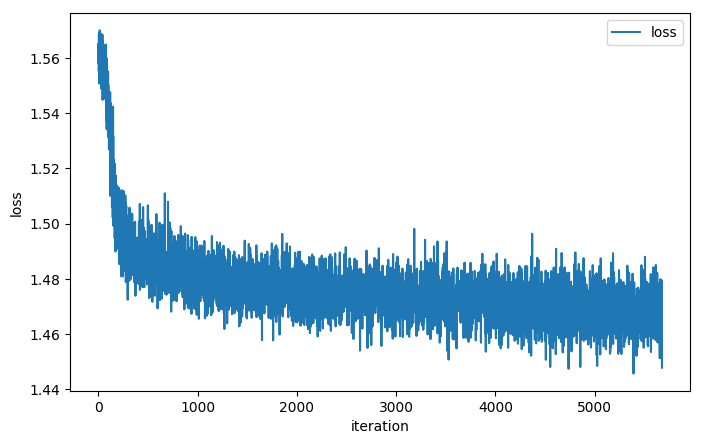

In [14]:
def save_lstm_loss_graph():
  
  train_loss = np.load(LSTM_TRAIN_LOSS_PATH)

  fig=plt.figure(figsize=(8, 5), dpi= 100, facecolor='w', edgecolor='k')
  line_train, = plt.plot(train_loss)

  plt.legend([line_train], ['loss'])
  plt.xlabel('iteration')
  plt.ylabel('loss')

  plt.savefig(GRAPHS_DIR + "/lstm_loss.png")
  plt.show()

if RUN_TESTS:
  save_lstm_loss_graph()

### Save vizualization of dreaming 

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/world_models_skiing/saved_models/vae/model/vae_model-24228


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


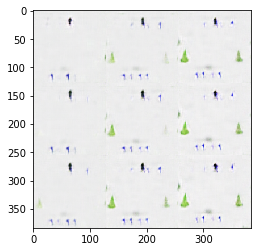

In [15]:

import scipy.misc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def show_prediction(num_w, num_h):
  """ Given a frame, tries to predict the next num_w x num_h encoded vectors 
    reconstruct them and save all to one image.
  """

  # Load modules and encode first frame 
  sess, vae = load_vae()
  lstm = load_lstm()
  lstm.hidden = lstm.init_hidden(1)
  env = make_env()

  frame = env.reset()
  z = sess.run(vae.z, feed_dict={vae.original: frame.reshape(-1,128,128,3)})

  frames = np.array(frame)

  image = None

  

  with torch.no_grad():
    for i in range(num_w): 
      for j in range(num_h):
        recon = sess.run(vae.reconstruction, feed_dict={vae.z: z.reshape(-1,LATENT_Z_DIM)})

        if j == 0: 
          frames = recon[0]
        else:
          frames = np.vstack((frames, recon[0]))
        
        # Dreaming
        z = torch.tensor(z, dtype=torch.float, device=DEVICE).view(1, LATENT_Z_DIM)
        actions = torch.full((1, 1), env.action_space.sample(), device=DEVICE) / ACTION_SPACE_DISCRETE
        new_state = torch.cat((z,actions), dim=1)
        pi, sigma, mu = lstm(new_state.view(1, 1, LATENT_Z_DIM + 1))
        z = sample(1, pi, mu, sigma)

      if i == 0: 
        image = frames
      else: 
        image = np.hstack((image, frames))

  sess.close()



  scipy.misc.imsave(VISUALIZATIONS_DIR  + '/lstm_dream_{}_{}.jpg'.format(num_w,num_h), image)

  plt.imshow(image)
  plt.show()

if RUN_TESTS:
  show_prediction(3, 3)

# Controller


## Get CMA

In [16]:
!pip install cma==2.6.0

     |████████████████████████████████| 225kB 2.8MB/s 


## Controller Module

In [0]:
import torch
import numpy as np

from numpy.random import choice

class Controller():
  '''Object for the desicion mechanism.
     Can have multiple variants based on the type 
     and usage of the hidden state for prediction
  
  '''
  
  def __init__(self, sess, vae, lstm=None, c_type = 'softmax', no_hidden = False):
    '''Initialize controller
    
      Paramers:
        * sess, vae, lstm: Modules for fatures extraction
        * c_type (string): Type of the controller desicion mechanism 
        * hidden (bool): True - hidden state is used for the prediction
        
    '''
    
    self.sess = sess
    self.vae = vae
    self.lstm = lstm
    self.c_type = c_type
    self.no_hidden = no_hidden

    

    if self.c_type == 'softmax' or self.c_type == 'argmax':
      self.prediction_size = 3   

    elif self.c_type == 'tanh':
      self.prediction_size = 1

    elif self.c_type == 'random policy':
      self.prediction_size = 0
      self.no_hidden = True

    else:
      raise Exception('Unknown controller type: {}'.format(c_type))

      

    if self.no_hidden:
      self.emb_size = LATENT_Z_DIM 
    else:
      self.emb_size = LATENT_Z_DIM + (HIDDEN_DIM * 2)

      
    self.num_params = self.prediction_size * self.emb_size + self.prediction_size
    

  def softmax(self, x):

      """Compute softmax values for each sets of scores in x."""

      e_x = np.exp(x - np.max(x))

      return e_x / e_x.sum(axis=0) 


  def get_weights_bias(self, params):
    '''Take proposed arguments from CMA-ES 
      and split them as bias and weights
      
    '''
    
    weights = params[:self.num_params - self.prediction_size]
    bias = params[-self.prediction_size:]

    weights = np.reshape(weights, [self.emb_size, self.prediction_size])

    return weights, bias

  
  def update_lstm_hidden(self, vae_z, action):
    '''Update hidden state based on provided 
       latent vector and action
    
    '''
    
    with torch.no_grad():
      x = get_lstm_input(vae_z, action)
      _ = self.lstm(x)
  

  def init_hidden(self):

    if not self.no_hidden:
      self.lstm.hidden = self.lstm.init_hidden(1)

 
  def get_name(self):

    hidden = ' no hidden' if self.no_hidden else ''

    return self.c_type + hidden

 
  def get_action(self, observation=None, params=None):
    '''Based on controller type propose an action
    
      Parameters:
       * observation (np.array(12,128,3)): Preprocessed observation from the environment
       * params (list): Solutions propose by cmaes module
       
      Returns: 
        * action (int)
        
    '''
    
    if self.c_type == 'random policy':
      return np.random.randint(3, size=1)
    
    
    # Encode observation to z
    vae_z = self.sess.run(self.vae.z, feed_dict={self.vae.original: observation[None, :,  :,  :]})

    # weights and biases
    weights, bias = self.get_weights_bias(params)

    if self.no_hidden:
      x = vae_z
    else:

      # Concate hidden vectors
      lstm_h = np.concatenate((self.lstm.hidden[0].view(1, -1).cpu().tolist()[0],\
                               self.lstm.hidden[1].view(1, -1).cpu().tolist()[0]))
      
      # Concate vae z and hidden vectors from lstm 
      x = np.concatenate((np.squeeze(vae_z), np.squeeze(lstm_h)))

    # Calculate prediction as Wx + B
    prediction = np.matmul(x, weights) + bias

   

    if self.c_type == 'argmax':
      action =  np.argmax(prediction)    

    elif self.c_type == 'softmax':
      if self.no_hidden:
        prediction = prediction[0]

      prediction = self.softmax(prediction)
      action = choice(range(len(prediction)), p=prediction)

    elif self.c_type == "tanh":
      prediction = np.tanh(prediction)

      if prediction < 0 - 2/3:
        action = 0
      elif prediction <  0 + 2/3:
        action = 1
      else:
        action = 2

      
    # Update hidden
    if not self.no_hidden:  
      self.update_lstm_hidden(vae_z, action)

    

    return action

  

def get_controller_types(types_range = 'trainable'):
  ''' Return list of names based on argument
      * tanh is in the thesis called SVO
  '''
  types = ['softmax', 'argmax', 'tanh']

  no_hidden_types = [ _type + ' no hidden' for _type in types]

  if types_range == 'basic':
    return types
  
  if types_range == 'no hidden':
        return no_hidden_types
    
  if types_range == 'trainable':
    types.extend(no_hidden_types)

  else:
    types.extend(no_hidden_types).append('random policy')

  

  return types

## Play function

In [0]:
import collections
import numpy as np

import cma, pickle

def play(controller, params, num_trials = 3, max_steps = 500, final_test = False):
  '''Evaluate providedd parameters on the controller
  
    Parameters:
      * controller (Controller): Decides actions
      * params (list): Weights and biases proposed by CMA-ES
      * num_trials (int): Number of evaluation for the average result
      * max_steps (int): Number of maximal steps before ending the game
      * final_test (bool): True - controller is evaluated on the original environment
                           False - controller is evaluated on training environment with artificial reward
                                   and shortened play time
    Returns:
     * avg_reward (float): Averaged cumulative reward
     
  '''
  
  DUMMY_RANGE = 10000
 
  env = make_env(env_reward=final_test)
  agent_rewards = []

  if final_test: 
    max_steps = DUMMY_RANGE

 

  for i_trial in range(num_trials):

    c_reward = []
    actions = []

    

    controller.init_hidden()  
    observation = env.reset()   

    for i_step in range(max_steps):

      if i_step % SEQUENCE == 0:
        controller.init_hidden()

      action = controller.get_action(observation, params)
      observation, reward, done, _ = env.step(action)

      actions.append(action)      
      c_reward.append(reward) 

      if done :
        break

    # Average reward
    agent_rewards.append(np.sum(c_reward))

  avg_reward = np.mean(agent_rewards) 

  if VERBOSE:
    print("\n==Agent {} ==".format(controller.get_name()) )
    print("=== avg. reward {0:.2f}===\n".format(avg_reward))

  

  if final_test:
    return agent_rewards

  

  # Correction for es.tell application
  return - avg_reward





## Different controller approaches training

In [0]:

NUM_GENERATIONS = 26

def train(controller):
  '''Find weights for controller using CMA-ES'''
  
  # Prepare or load variables
  
  PHENOTYPE = controller.num_params * [0]
  SIGMA = 0.1
  POPULATION_SIZE = 30
  es = cma.CMAEvolutionStrategy(PHENOTYPE, SIGMA, {'popsize': POPULATION_SIZE})

  
  rewards_history = np.zeros(4)
  play_rewards = np.empty((0))
  generation = 0
  try:
    
    es = pickle.load(open(CONTROLLER_DIR +'/saved-cma-object_{}.pkl'.format(controller.get_name()), 'rb'))
    rewards_history = np.load(CONTROLLER_DIR + '/rewards_history_{}.npy'.format(controller.get_name()))
    

    generation = len(rewards_history)
    if VERBOSE:
      print('**Resumed saved cma**')
      print("Continuing on generation: {}".format(generation))
  
  except Exception as e:
    print('unable to load cma {}'.format(e))

  try:
    while not es.stop():
 
      play_rewards = np.empty((0))
  
      #A list of POPULAION_SIZE candidate solutions to be evaluated
      solutions = es.ask()
      
      for i, solution in enumerate(solutions):
        if VERBOSE: 
          print("Solution: {}".format(i))
        play_rewards = np.append(play_rewards, play(controller, solution))
       
      # Compare and prepare for next run 
      es.tell(solutions, play_rewards)
      
      play_rewards = play_rewards *(-1.)
      
      if VERBOSE:
        print("Playing best")
      best_play_reward =  play(controller, es.best.get()[0]) * (-1.) 

      if VERBOSE:
        print("\n======================")
        print("Generation: {}".format(generation))
        print("Min reward: {:.2f}".format(np.min(play_rewards)))
        print("Max reward: {:.3f}".format(np.max(play_rewards)))
        print("Avg reward: {:.2f}".format(np.mean(play_rewards)))
        print("Play reward: {:.2f}".format(best_play_reward))
        print("======================\n")

      generation+=1
      
      # Save rewards and controller
      try:
        rewards_history = np.vstack([rewards_history,  [np.min(play_rewards), np.max(play_rewards), np.mean(play_rewards), best_play_reward]])

        pickle.dump(es, open(CONTROLLER_DIR + '/saved-cma-object_{}.pkl'.format(controller.get_name()), 'wb'))
        np.save(CONTROLLER_DIR + '/rewards_history_{}.npy'.format(controller.get_name()), rewards_history)
      except Exception as e:
        print("Error whlie saving cma objects: {}".format(e))
      
      if generation > NUM_GENERATIONS:
        break
        
  except (KeyboardInterrupt, SystemExit):
    print("Manual Interrupt")
    return es
  except Exception as e:
    print("Exception: {}".format(e))
  return es


if RETRAIN_CONTROLLER:
  # For retraning specific controller change c_type and no_hidden argument
  sess, vae = load_vae()
  lstm = load_lstm()  
  controller = Controller(sess, vae, lstm = None, c_type = "argmax", no_hidden = True)
  train(controller)

## Plotting results of the training

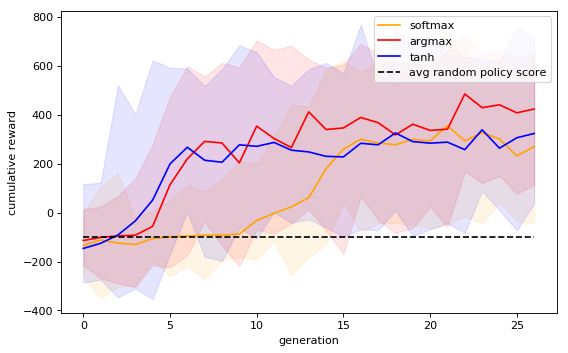

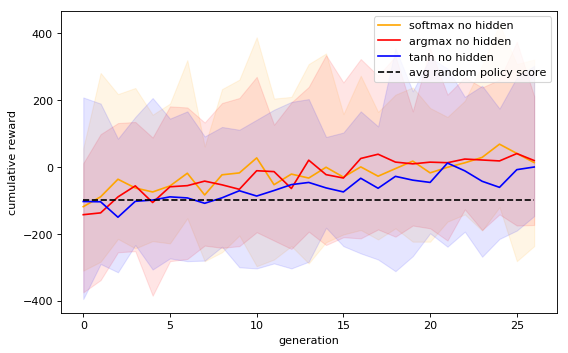

In [20]:
import numpy as np;
import matplotlib.pyplot as plt

AVG_RANDOM_POLICY = -99.75 


import matplotlib as mpl

def show_controller_progress_graph(data, name):
  '''Shows progress for individual technique'''
  
  random_policy = np.empty(len(data))
  random_policy.fill(AVG_RANDOM_POLICY)

  fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')

  line_min, = plt.plot( data[:, 0])
  line_max, = plt.plot(data[:, 1])
  line_mean, = plt.plot( data[:, 2])
  line_best, = plt.plot( data[:, 3])

  plt.legend([line_mean, line_min, line_max, line_best], ['mean', 'min', 'max', 'best avg score'])

  plt.xlabel('generation')
  plt.ylabel('cumulative reward')

  plt.title(name)
  plt.fill_between(range(len(data[:,0])), data[:,1], data[:,0],  color='grey', alpha='0.3')

  plt.show()

def plot_controllers_progress(results, c_type):
  '''Plot all controllers progress to the single graph'''
  
  fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
  
  y = []
  names = []
  colors = ['orange', 'red', 'blue']
  
  for i, (name, data) in enumerate(results.items()):

    line_mean, = plt.plot( data[:, 2], color=colors[i])
    
    y.append(line_mean)
    names.append(name)

    plt.fill_between(range(len(data[:,0])), data[:,1], data[:,0],  color=colors[i], alpha='0.1')

  line_random, = plt.plot(np.full(NUM_GENERATIONS + 1,-99.75),  '--', color='black')  

  y.append(line_random)
  names.append('avg random policy score')

  plt.legend(y, names)
  plt.xlabel('generation')
  plt.ylabel('cumulative reward')

  plt.savefig(GRAPHS_DIR + "/c_progress_{}.svg".format(c_type))

  plt.show()



def compare_controllers_results(appraoches, c_type):
  
  results = {}
  names = []
  for approach in approaches: 

    data = np.load(CONTROLLER_DIR + f'/rewards_history_{approach}.npy')
    data = data[:NUM_GENERATIONS+2]
    results[approach] = data[1:]
    
  plot_controllers_progress(results, c_type )



if RUN_TESTS:
  approaches = get_controller_types(types_range = 'basic')
  compare_controllers_results(approaches, "- z and h")
  approaches = get_controller_types(types_range = 'no hidden')
  compare_controllers_results(approaches, "- only z")
  # show_controller_progress_graph(data, approach)

## Testing trained solution on real environment

In [21]:
def test_best_solutions(c_type = 'argmax', original_env = True):
  '''Test performance of the desicion method
    Parameters: 
      * c_type (string): Full name of the controller type
      * original_env (bool): True - Original environment is used for performance testing
                             False - Environment with artificial reward and shortened game is used 
                             
  '''
  
  sess, vae = load_vae()
  lstm = load_lstm()  

  # Create controller
  if ' no hidden' in c_type:
    controller = Controller(sess, vae, lstm = None, c_type = c_type[:-len(' no hidden')] , no_hidden = True)
  else:
    controller = Controller(sess, vae, lstm = lstm, c_type = c_type, no_hidden = False)
  
  # Load saved results if exists
  c_rewards = np.empty([0])
  
  try:
    c_rewards = np.load(CONTROLLER_DIR + '/best_params_rewards_{}_{}.npy'.format(controller.get_name(), original_env))
  except Exception as e:
    print("Exception: {}".format(e))

  es = pickle.load(open(CONTROLLER_DIR +'/saved-cma-object_{}.pkl'.format(c_type), 'rb'))                      
  best_params = es.best.get()[0]

  
  print('Testing {} best solution'.format(c_type))
  
  c_rewards = np.append(c_rewards, play(controller, best_params, num_trials = 20, final_test = original_env))
  np.save(CONTROLLER_DIR + '/best_params_rewards_{}_{}.npy'.format(controller.get_name(), original_env), c_rewards)
  
  print("Average reward for {}: {}".format(c_type, np.mean(c_rewards)))
  


if RUN_TESTS:  
  test_best_solutions()


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/world_models_skiing/saved_models/vae/model/vae_model-24228
Testing argmax best solution
Average reward for argmax: -11623.25
